In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('../../Dataset/DXG Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,150.0","15,400.0","15,500.0","15,000.0",20.98M,0.00%
1,06/01/2023,"15,150.0","14,900.0","15,200.0","14,850.0",18.46M,1.68%
2,05/31/2023,"14,900.0","14,950.0","15,200.0","14,850.0",15.10M,-0.33%
3,05/30/2023,"14,950.0","14,950.0","15,200.0","14,750.0",30.20M,2.40%
4,05/29/2023,"14,600.0","14,650.0","14,750.0","14,500.0",13.24M,1.04%
...,...,...,...,...,...,...,...
1366,12/07/2017,"12,100.6","12,161.1","12,312.3","11,858.5",5.23M,-0.50%
1367,12/06/2017,"12,161.1","12,161.1","12,342.6","11,919.0",7.72M,-0.99%
1368,12/05/2017,"12,282.1","12,705.6","12,917.3","12,282.1",11.06M,-3.33%
1369,12/04/2017,"12,705.6","12,463.6","12,705.6","12,282.1",9.42M,3.70%


In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15150.0,15400.0,15500.0,15000.0,20980000.0,0.0000
1,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168
2,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
3,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
4,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
...,...,...,...,...,...,...,...
1366,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
1367,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
1368,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
1369,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370


In [5]:
df=df.set_index('Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033


In [6]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,1371.000000,1371.000000,1371.000000,1371.000000,1.371000e+03,1371.000000
mean,17674.362509,17660.057695,18070.651058,17290.551860,7.081185e+06,0.000702
std,7590.149172,7578.982544,7806.761118,7367.071153,5.709696e+06,0.032425
min,6739.100000,6269.600000,6947.800000,6269.600000,4.483700e+05,-0.070000
25%,12395.650000,12434.800000,12608.700000,12220.800000,2.750000e+06,-0.016300
50%,16066.500000,16100.000000,16350.000000,15793.000000,5.640000e+06,0.000000
75%,20852.300000,20800.000000,21217.200000,20435.000000,9.835000e+06,0.019600
max,46750.000000,46500.000000,47450.000000,46200.000000,4.930000e+07,0.070000


In [7]:

import plotly.express as px
fig = px.line(df, x=df.index, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of DXG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [8]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int((len(df)-1) * 0.6)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
X = df[['Price']].iloc[:-1]
Y = df['Price'].shift(-1).iloc[:-1]

X_train, Y_train = X[:train_size], Y[:train_size]
X_test,Y_test = X[train_size:train_size+test_size],Y[train_size:train_size+test_size]
X_val, Y_val = X[train_size+test_size:], Y[train_size+test_size:]
     

In [9]:
# Tạo dictionary params chứa các giá trị của tham số k
params = {'n_neighbors': [i for i in range(1, 30)]}

# Tạo một model KNN mới
knn_model = KNeighborsRegressor()

# Sử dụng GridSearchCV để tìm giá trị tối ưu của k dựa trên tập train
grid_search = GridSearchCV(knn_model, params, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# In giá trị tối ưu của k
print("Giá trị tối ưu của k:", grid_search.best_params_['n_neighbors'])

# Tạo một model KNN mới với k tối ưu được chọn
knn_model = KNeighborsRegressor(n_neighbors= grid_search.best_params_['n_neighbors'])

# Huấn luyện model trên tập train
knn_model.fit(X_train, Y_train)


Giá trị tối ưu của k: 12


KNeighborsRegressor(n_neighbors=12)

In [10]:
print(Y_train)

Date
2017-12-01    12705.6
2017-12-04    12282.1
2017-12-05    12161.1
2017-12-06    12100.6
2017-12-07    12070.3
               ...   
2021-03-16    21304.3
2021-03-17    21913.0
2021-03-18    22087.0
2021-03-19    21434.8
2021-03-22    20826.1
Name: Price, Length: 822, dtype: float64


In [11]:
pred_dates=Y_test.index
last_price=Y_train.iloc[-1]
Y_pred=Y_test.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred.loc[date]=pred[0] 
  last_price=pred[0]     


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [12]:
print(Y_pred)

Date
2021-03-23    20553.716667
2021-03-24    20271.516667
2021-03-25    20282.433333
2021-03-26    20282.433333
2021-03-29    20282.433333
                  ...     
2022-04-20    20282.433333
2022-04-21    20282.433333
2022-04-22    20282.433333
2022-04-25    20282.433333
2022-04-26    20282.433333
Name: Price, Length: 274, dtype: float64


In [13]:
pred_dates=Y_val.index
last_price=Y_test.iloc[-1]
Y_pred_val=Y_val.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred_val.loc[date]=pred[0] 
  last_price=pred[0]    
print(Y_pred_val)

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



Date
2022-04-27    22988.433333
2022-04-28    22810.066667
2022-04-29    22731.833333
2022-05-04    22496.575000
2022-05-05    22405.825000
                  ...     
2023-05-26    21872.283333
2023-05-29    21974.241667
2023-05-30    21872.283333
2023-05-31    21974.241667
2023-06-01    21872.283333
Name: Price, Length: 274, dtype: float64


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [14]:
last_date=Y_val.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = Y_val.iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

         Date         Close
0  2023-06-02  15352.333333
1  2023-06-03  15493.766667
2  2023-06-04  15499.633333
3  2023-06-05  15528.625000
4  2023-06-06  15528.625000
5  2023-06-07  15528.625000
6  2023-06-08  15528.625000
7  2023-06-09  15528.625000
8  2023-06-10  15528.625000
9  2023-06-11  15528.625000
10 2023-06-12  15528.625000
11 2023-06-13  15528.625000
12 2023-06-14  15528.625000
13 2023-06-15  15528.625000
14 2023-06-16  15528.625000
15 2023-06-17  15528.625000
16 2023-06-18  15528.625000
17 2023-06-19  15528.625000
18 2023-06-20  15528.625000
19 2023-06-21  15528.625000
20 2023-06-22  15528.625000
21 2023-06-23  15528.625000
22 2023-06-24  15528.625000
23 2023-06-25  15528.625000
24 2023-06-26  15528.625000
25 2023-06-27  15528.625000
26 2023-06-28  15528.625000
27 2023-06-29  15528.625000
28 2023-06-30  15528.625000
29        NaT  15528.625000


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(Y_val, Y_pred_val)
test_mape = mean_absolute_percentage_error(Y_test, Y_pred)
valid_rmse = np.sqrt(np.mean((Y_pred_val - Y_val)**2))
test_rmse = np.sqrt(np.mean((Y_pred - Y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 7682.102033679121
Testing RMSE: 11047.771595947055
Validation MAPE: 0.49152325061334295
Testing MAPE: 0.2157621358355933


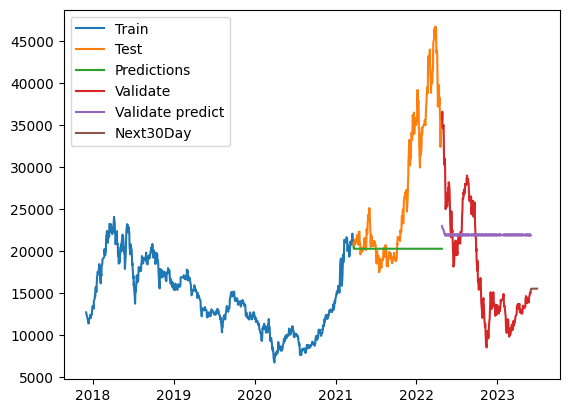

In [16]:
# 9.Vẽ hình
plt.plot(Y_train.index, Y_train)
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, Y_pred)
plt.plot(Y_val.index, Y_val)
plt.plot(Y_val.index, Y_pred_val)
plt.plot(forecast_df['Date'], forecast_df['Close'])
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate predict','Next30Day'])
plt.show()

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



         Date         Close
0  2023-06-03  15088.433333
1  2023-06-04  14892.675000
2  2023-06-05  14840.308333
3  2023-06-06  14813.441667
4  2023-06-07  14718.958333
5  2023-06-08  14775.841667
6  2023-06-09  14604.641667
7  2023-06-10  14693.333333
8  2023-06-11  14735.750000
9  2023-06-12  14775.841667
10 2023-06-13  14604.641667
11 2023-06-14  14693.333333
12 2023-06-15  14735.750000
13 2023-06-16  14775.841667
14 2023-06-17  14604.641667
15 2023-06-18  14693.333333
16 2023-06-19  14735.750000
17 2023-06-20  14775.841667
18 2023-06-21  14604.641667
19 2023-06-22  14693.333333
20 2023-06-23  14735.750000
21 2023-06-24  14775.841667
22 2023-06-25  14604.641667
23 2023-06-26  14693.333333
24 2023-06-27  14735.750000
25 2023-06-28  14775.841667
26 2023-06-29  14604.641667
27 2023-06-30  14693.333333
28 2023-07-01  14735.750000
29        NaT  14775.841667


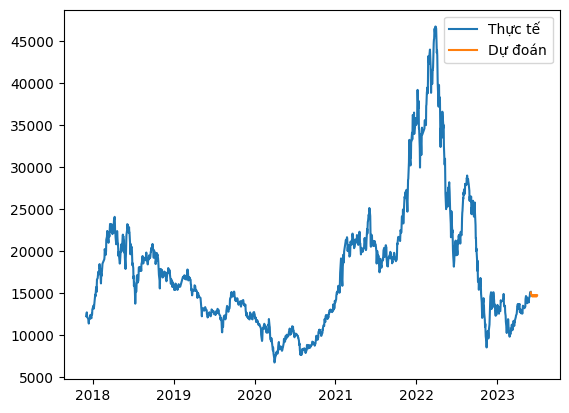

In [17]:

# Xây dựng lại mô hình trên toàn bộ dữ liệu
knn_model = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_model.fit(X, Y)

# Dự đoán giá đóng cửa của 30 ngày tiếp theo
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = df['Price'].iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

# Vẽ biểu đồ dự đoán
plt.plot(df.index, df['Price'], label='Thực tế')
plt.plot(forecast_df['Date'], forecast_df['Close'], label='Dự đoán')
plt.legend()
plt.show()